In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from glob import glob
import rispy
from IPython.display import display

In [2]:
# Display full text in all columns
pd.set_option("display.max_colwidth", None)

# Optional: Increase the number of displayed rows and columns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
WOS_papers = pd.read_excel("./WOS/wos.xls")
ris_files = glob("./ScienceDirect/*.ris")
SCO_papers = pd.read_csv("./Scopus/scopus.csv")

# List to store each DataFrame
dfs = []

# Process each .ris file and append to the list of DataFrames
for ris_file in ris_files:
    with open(ris_file, "r", encoding="utf-8") as file:
        entries = rispy.load(file)  # Parse .ris file using rispy
        df = pd.DataFrame(entries)  # Convert each file to a DataFrame
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
SD_papers = pd.concat(dfs, ignore_index=True)

In [4]:
# # Merge 'Author Keywords' and 'Keywords Plus' in WOS_papers
# WOS_papers["Keywords"] = WOS_papers["Author Keywords"].fillna("") + "; " + WOS_papers["Keywords Plus"].fillna("")
# WOS_papers["Keywords"] = WOS_papers["Keywords"].str.strip("; ")

# # Merge 'Author Keywords' and 'Index Keywords' in SCO_papers
# SCO_papers["Keywords"] = SCO_papers["Author Keywords"].fillna("") + "; " + SCO_papers["Index Keywords"].fillna("")
# SCO_papers["Keywords"] = SCO_papers["Keywords"].str.strip("; ")

In [5]:
print(WOS_papers.shape[0])
print(SCO_papers.shape[0])
print(SD_papers.shape[0])

184
560
142


In [6]:
# Rename columns to match the common fields in all dataframes
WOS_papers = WOS_papers.rename(columns={"Article Title": "Title", "Abstract": "Abstract", "Authors": "Authors", "DOI": "DOI", "ISSN": "ISSN", "Publication Year": "Publication Year"})

SCO_papers = SCO_papers.rename(columns={"Article Title": "Title", "Abstract": "Abstract", "Authors": "Authors", "DOI": "DOI", "ISSN": "ISSN", "Publication Year": "Publication Year"})

SD_papers = SD_papers.rename(columns={"primary_title": "Title", "abstract": "Abstract", "authors": "Authors", "doi": "DOI", "issn": "ISSN", "year": "Publication Year", "keywords": "Keywords"})

In [7]:
# For WOS_papers
WOS_papers["Keywords"] = WOS_papers["Author Keywords"].fillna("") + "; " + WOS_papers["Keywords Plus"].fillna("")
# Clean and convert to set format
WOS_papers["Keywords"] = WOS_papers["Keywords"].str.strip("; ").str.lower().apply(lambda x: {kw.strip() for kw in x.split(";") if kw.strip()} if isinstance(x, str) and x else set())

# For SCO_papers
SCO_papers["Keywords"] = SCO_papers["Author Keywords"].fillna("") + "; " + SCO_papers["Index Keywords"].fillna("")
# Clean and convert to set format
SCO_papers["Keywords"] = SCO_papers["Keywords"].str.strip("; ").str.lower().apply(lambda x: {kw.strip() for kw in x.split(";") if kw.strip()} if isinstance(x, str) and x else set())

# For SD_papers
# Ensure only valid lists are processed and convert to sets
SD_papers["Keywords"] = SD_papers["Keywords"].apply(lambda lst: {kw.lower().strip() for kw in lst if kw.strip()} if isinstance(lst, list) else set())

In [8]:
common_columns = ["Title", "Abstract", "Authors", "Keywords", "DOI", "ISSN", "Publication Year"]

WOS_papers_common = WOS_papers[common_columns]
SCO_papers_common = SCO_papers[common_columns]
SD_papers_common = SD_papers[common_columns]

In [9]:
print(WOS_papers_common.columns[WOS_papers_common.columns.duplicated()])
print(SCO_papers_common.columns[SCO_papers_common.columns.duplicated()])
print(SD_papers_common.columns[SD_papers_common.columns.duplicated()])

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


In [10]:
combined_df = pd.concat([WOS_papers_common, SCO_papers_common, SD_papers_common], ignore_index=True)

In [11]:
combined_df.to_csv("./COMBINED.csv")

In [12]:
combined_df.shape[0]

886

In [18]:
keyword_counts = {}
for i, element in enumerate(combined_df[combined_df["Keywords"].notnull()]["Keywords"]):
    # split = element.split(";") if type(element) is str else print("FUCK FUCK", element)
    # print(split)
    for kw in element:
        kw = kw.strip().lower()
        if kw not in keyword_counts:
            keyword_counts[kw] = 1
        else:
            keyword_counts[kw] += 1

# Convert the dictionary to a DataFrame
keywords_df = pd.DataFrame(list(keyword_counts.items()), columns=["keyword", "count"])

# Sort the DataFrame by count in descending order (optional)
keywords_df = keywords_df.sort_values(by="count", ascending=False).reset_index(drop=True)

print(keywords_df)

                        keyword  count
0                      workload    123
1                    ergonomics    113
2                      workers'    105
3                      assembly    100
4                         human     79
...                         ...    ...
5259  solar energy applications      1
5260    production requirements      1
5261             thermal stress      1
5262      physiological process      1
5263             3d interaction      1

[5264 rows x 2 columns]


In [14]:
combined_df.columns

Index(['Title', 'Abstract', 'Authors', 'Keywords', 'DOI', 'ISSN',
       'Publication Year'],
      dtype='object')

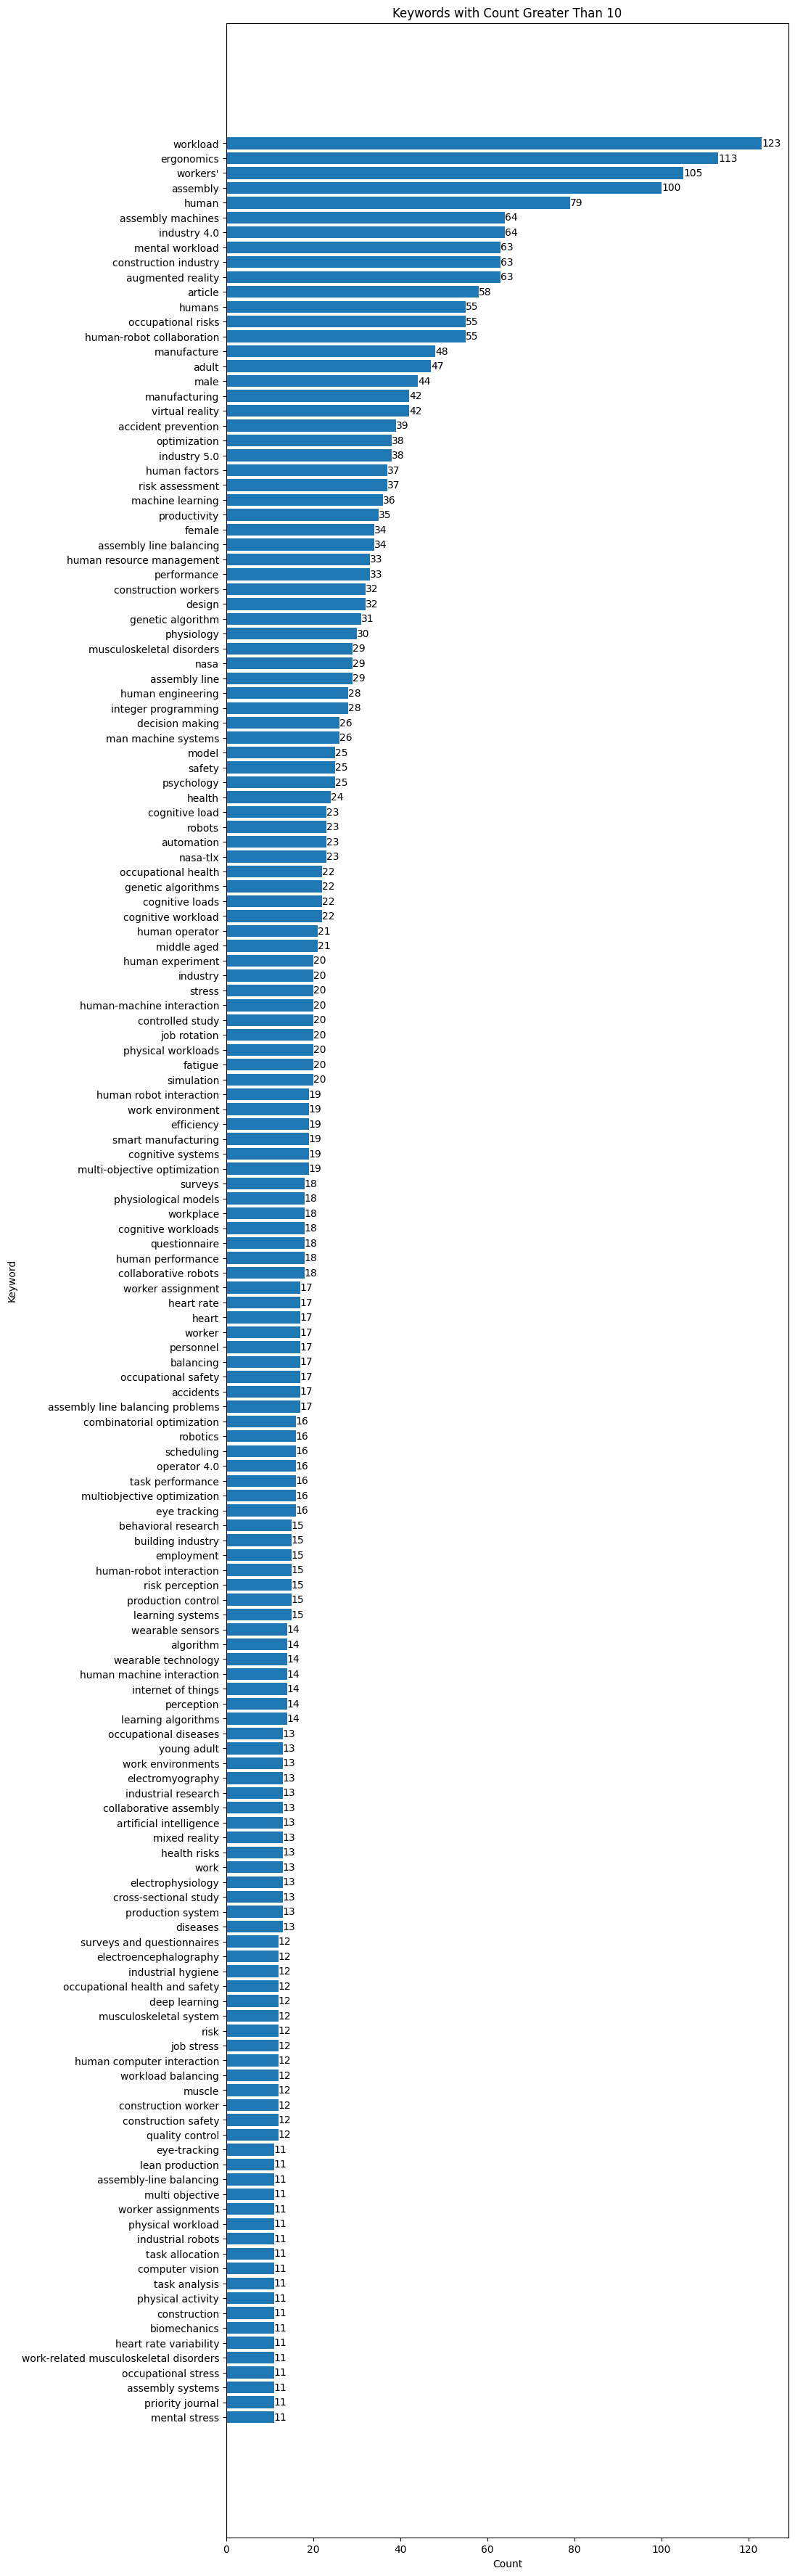

In [15]:
# Filter keywords that have a count greater than 1
keywords_df_filtered = keywords_df[keywords_df["count"] > 10]

# Plotting
plt.figure(figsize=(10, 45))
plt.barh(keywords_df_filtered["keyword"], keywords_df_filtered["count"], align="center")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.title("Keywords with Count Greater Than 10")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top

# Adding count labels at the end of each bar
for index, value in enumerate(keywords_df_filtered["count"]):
    plt.text(value, index, str(value), va="center")

plt.show()

In [16]:
# Filter rows where any keyword contains "industry" as a substring
filtered_df = combined_df[combined_df["Keywords"].apply(lambda keywords: any("cognitive" in kw for kw in keywords))]

# Display the number of matching rows and the first few rows of the filtered DataFrame
print(filtered_df.shape[0])
display(filtered_df.head())

100


,Title,Abstract,Authors,Keywords,DOI,ISSN,Publication Year
2,Experimental study to investigate mental workload of local vs remote operator in human-machine interaction,"A new Coronavirus disease 2019 has spread globally since 2019. Consequently, businesses from different sectors were forced to work remotely. At the same time, research in this area has seen a rise in studying and emerging technologies that allow and promote such a remote working style; not every sector is equipped for such a transition. The manufacturing sector especially, has faced challenges in this respect. This paper investigates the mental workload (MWL) of two groups of participants through a human-machine interaction task. Participants were required to bring a robotised cell to full production by tuning system and dispensing process parameters. Following the experiment, a self-assessment of the participants' perceived MWL using the raw NASA Task Load Index (RTLX) was collected. The results reveal that remote participants tend to have a lower perceived workload compared to the local participants, but mental demand was deemed higher while performance was rated lower.","Zimmer, M; Al-Yacoub, A; Ferreira, P; Hubbard, EM; Lohse, N","{ergonomics, mental workload, visual information, collaboration, human-machine interaction, remote working, rtlx, nasa-tlx, cognitive load assessment}",10.1080/21693277.2022.2090458,NaN,2022
6,On the development of a method for cognitive load assessment in manufacturing,"The increasing complexity and demands of assembly operations in manufacturing has been shown to lead to increased cognitive load in assembly workers. Previous work has outlined the complexity of an assembly worker's situation both in terms of difficulty and speed of work and there have been a few attempts at creating frameworks and methods for understanding the key aspects of what creates increased cognitive load. This paper presents the development of an analytic method, denoted CLAM (Cognitive Load Assessment for Manufacturing), and a tool for assessing cognitive load in manufacturing, primarily assembly. It outlines the journey of the development as well as discusses and problematizes relevant meta-methodological issues paired with method development. The intended contribution of the work is to make a difference in reducing the cognitive load of assembly workers on the shop floor, thus focusing the development on applicability and usability of the tool in practice. With this purpose in mind, focus of the method development has been on the practitioners, i.e. the method should not require any expert knowledge to be applied. The CLAM method and accompanying documentation such as a handbook containing instructions towards using the method and interpreting the results, is available in an online tool.","Thorvald, P; Lindblom, J; Andreasson, R","{cognitive load, mental workload, method development, clam method, assembly, manufacturing, design}",10.1016/j.rcim.2019.04.012,0736-5845,2019
10,Overloaded and at Work: Investigating the Effect of Cognitive Workload on Assembly Task Performance,"Objective This study investigates the effect of cognitive overload on assembly task performance and muscle activity. Background Understanding an operator's cognitive workload is an important component in assessing human-machine interaction. However, little evidence is available on the effect that cognitive overload has on task performance and muscle activity when completing manufacturing tasks. Method Twenty-two volunteers completed an assembly task while performing a secondary cognitive task with increasing levels of demand (n-back). Performance in the assembly task (completion times, accuracy), muscle activity recorded as integrated electromyography (EMG), and self-reported workload were measured. Results Results show that the increasing cognitive demand imposed by then-back task resulted in impaired assembly task performance, overall greater muscle activity, and higher self-report

In [76]:
# Define the list of search terms
search_terms = ["cognitive measurement"]

# Filter rows where any term appears in Keywords, Title, or Abstract
filtered_df = combined_df[combined_df["Keywords"].apply(lambda keywords: any(term in kw for kw in keywords for term in search_terms)) | combined_df["Title"].apply(lambda title: any(term.lower() in title.lower() for term in search_terms) if pd.notnull(title) else False) | combined_df["Abstract"].apply(lambda abstract: any(term.lower() in abstract.lower() for term in search_terms) if pd.notnull(abstract) else False)]

# Display the number of matching rows and the first few rows of the filtered DataFrame
print(filtered_df.shape[0])
display(filtered_df.head(1))

0


,Title,Abstract,Authors,Keywords,DOI,ISSN,Publication Year


In [78]:
# Define the list of search terms
search_terms = [
    "Worker",
    "Industry",
    "Human",
    "Manufacturing",
    "Operator",
    "Industrial",
    "Assembly Line",
    "Cognitive Load",
    "Industry 4.0",
    "Mental Workload",
    "Human Operator",
    "Factory",
    "Collaborative Robot",
    "Industry 5.0",
    "Cognitive Workload",
    "Human-Machine Interaction",
    "Production Line",
    "Human-Centric",
    "Cabot",
    "Task Load",
    "Shop Floor",
    "Assembly Worker",
    "Cognitive Load Assessment",
    "Cognitive Demand",
    "Cognitive Effort",
    "Industrial Workplace",
    "Cognitive Assessment",
    "Mental Effort",
    "Cognitive Measurement",
]

# Dictionary to store search terms and their respective row counts
search_term_counts = {}

# Iterate over each search term and calculate the number of matching rows
for term in search_terms:
    count = combined_df[combined_df["Keywords"].apply(lambda keywords: any(term in kw for kw in keywords)) | combined_df["Title"].apply(lambda title: term.lower() in title.lower() if pd.notnull(title) else False) | combined_df["Abstract"].apply(lambda abstract: term.lower() in abstract.lower() if pd.notnull(abstract) else False)].shape[0]

    # Store the count in the dictionary
    search_term_counts[term] = count

# Display the results
search_term_counts = dict(sorted(search_term_counts.items(), key=lambda item: item[1], reverse=True))
search_term_counts

{'Worker': 754,
 'Industry': 451,
 'Human': 394,
 'Manufacturing': 336,
 'Operator': 221,
 'Industrial': 183,
 'Assembly Line': 148,
 'Cognitive Load': 110,
 'Human Operator': 104,
 'Mental Workload': 103,
 'Industry 4.0': 81,
 'Factory': 70,
 'Collaborative Robot': 63,
 'Industry 5.0': 55,
 'Cognitive Workload': 39,
 'Production Line': 36,
 'Human-Centric': 29,
 'Human-Machine Interaction': 27,
 'Task Load': 26,
 'Shop Floor': 19,
 'Assembly Worker': 14,
 'Cognitive Demand': 12,
 'Cognitive Load Assessment': 11,
 'Cognitive Effort': 3,
 'Industrial Workplace': 2,
 'Cognitive Assessment': 1,
 'Cabot': 0,
 'Mental Effort': 0,
 'Cognitive Measurement': 0}

In [ ]:
keyword_counts = {}
for i, element in enumerate(combined_df[combined_df["Keywords"].notnull()]["Keywords"]):
    # split = element.split(";") if type(element) is str else print("FUCK FUCK", element)
    # print(split)
    for kw in element:
        kw = kw.strip().lower()
        if kw not in keyword_counts:
            keyword_counts[kw] = 1
        else:
            keyword_counts[kw] += 1

# Convert the dictionary to a DataFrame
keywords_df = pd.DataFrame(list(keyword_counts.items()), columns=["keyword", "count"])

# Sort the DataFrame by count in descending order (optional)
keywords_df = keywords_df.sort_values(by="count", ascending=False).reset_index(drop=True)

print(keywords_df)